In [82]:
# Imports
import pandas as pd
import glob
import numpy as np
import matplotlib
from matplotlib import image
from matplotlib import pyplot as plt
import scipy.stats
import itertools
from collections import Counter

In [83]:
# matplotlib.rc('font', family='sans-serif') 
# matplotlib.rc('font', serif='Fira Code') 
# matplotlib.rc('text', usetex='false') 
# matplotlib.rcParams.update({'font.size': 22})

In [84]:
# Constants
DATA_GLOB = '6G-Survey*.csv'
IMAGE_PATH = 'Map.php'
KM_PER_PX = 385/500 # Measured on the image
TEXT_TO_NUMERIC = {
    # fimilarity
    "Not familiar at all": 0,
    "Slightly familiar": 1,
    "Moderately familiar": 2,
    "Very familiar": 3,
    "Extremely familiar": 4,
    # ammount
    "Not at all": 0,
    "A little": 1,
    "A moderate amount": 2,
    "A lot": 3,
    "A great deal": 4,
    # bool
    "No": -1,
    "Maybe": 0,
    "Yes": 1,
    # agree
    "Strongly disagree": -2,
    "Somewhat disagree": -1,
    "Neutral": 0,
    "Somewhat agree": 1,
    "Strongly agree": 2,
    # time (unit is per day)
    "Never": 0,
    "Infrequently": 1 / 30,
    "Weekly": 1 / 7,
    "Daily": 1,
    "Multiple times a day": 2,
    # ages (just use average age, assume even distribution)
    "0-17": np.nan,
    "18-29": (18 + 29) / 2,
    "30-44": (30 + 44) / 2,
    "45-59": (45 + 59) / 2,
    "60+": (60 + 75) / 2,
    # gender
    # this isn't really a number but it needs to be for the
    # correlation math to work out. Ignores non male/female
    "Male": -1,
    "Female": 1,
    "Non-binary / third gender": np.nan,
    "Prefer not to say": np.nan,
}
CONCERNS = [
    "Privacy",
    "Initial cost of instillation",
    "Increased cost to use the system",
    "Reliability",
    "Dependence on internet connection",
    "Security risks",
    "Other. please specify:",
]
NUMERIC_QUESTIONS = [
    "Q12",  # How often do you use public transportation?
    "Q7",  # How familiar are you with 5G technology?
    "Q10",  # How much has 5G affected your quality of life?
    "Q11",  # How familiar are you with AI technology?
    "Q18",  # Would you prefer this over the current system?
    "Q19",  # This system would positively affect your quality of life.
    # "Q23",  # Would these considerations change any of your answers in the previous section?
    "Q25",  # Would you prefer this over the current system?
    "Q30",  # This system would positively affect your quality of life.
    "Q28",  # Select your age range.
    "Q29",  # Select your gender.
]

MULTIPLE_CHOICE_QUESTIONS = [
    
]

QUESTION_LOOKUP_TABLE = {
    "Q31": "What country are you from?",
    "Q12": "How often do you use public transportation?",
    "Q7": "How familiar are you with 5G technology?",
    "Q10": "How much has 5G affected your quality of life?",
    "Q11": "How familiar are you with AI technology?",
    "Q18": "Would you prefer this over the current system (Initial)?",
    "Q19": "This system would positively affect your quality of life (Initial).",
    "Q23": "Would these considerations change any of your answers in the previous section?",
    "Q25": "Would you prefer this over the current system (Final)?",
    "Q30": "This system would positively affect your quality of life (Final).",
    "Q28": "Select your age range.",
    "Q29": "Select your gender.",
    "Q21": "Initial concerns.",
    "Q27": "Final concerns.",
}

for question in ("Q21", "Q27"):
    for i, concern in enumerate(CONCERNS):
        MULTIPLE_CHOICE_QUESTIONS.append(f"{question}-{i}")
        QUESTION_LOOKUP_TABLE[f"{question}-{i}"] = f"{QUESTION_LOOKUP_TABLE[question][:-1]} - {concern}"

In [85]:
# Data pre-processing
data_path = glob.glob(DATA_GLOB)[0]
data = pd.read_csv(data_path)
data = pd.read_csv(data_path)
# remove extra data at top
data = data.iloc[2:, :]

print(f"Total responses: {len(data)}")

# only use finished responses from Taiwan
data = data[
    (data["Q31"] == "Taiwan") & (data["Finished"] == "True") & (data["Q28"] != "0-17")
]

print(f"Total usable responses: {len(data)}")

raw_data = data.copy()

# convert string dates to datetime objects
data["StartDate"] = pd.to_datetime(data["StartDate"])
data["EndDate"] = pd.to_datetime(data["EndDate"])

def add_concerns_columns(data: pd.DataFrame, question: str) -> pd.DataFrame:
    # set of indices of the concerns selected
    concerns_idx_table = (
        data[question]
        .apply(lambda x: None if pd.isna(x) else x) # turn nan into None
        # remove the , from the other question. replace with a period
        .apply(lambda x: x.replace("Other, please specify:", "Other. please specify:") if x is not None and "Other, please specify:" in x else x)
        .apply(lambda x: x.split(",") if x is not None else []) # turn csv into list
        .apply(lambda l: {CONCERNS.index(x) for x in l}) # convert list to list of concerns indices
    )

    # add col for each concern to the df
    for i in range(len(CONCERNS)):
        data[f"{question}-{i}"] = [0] * len(data)

    for row_idx, concerns_idx in concerns_idx_table.items():
        for concern_idx in concerns_idx:
            data.loc[row_idx, f"{question}-{concern_idx}"] = 1
    
    return data

# change concerns questions to be boolean values in seperate columns
data = add_concerns_columns(data, "Q21")
data = add_concerns_columns(data, "Q27")

# convert everything possible to numeric
f = lambda x: TEXT_TO_NUMERIC[x] if x in TEXT_TO_NUMERIC else x
for col in NUMERIC_QUESTIONS + MULTIPLE_CHOICE_QUESTIONS:
    data[col] = data[col].apply(f).astype(float)

data[["Q5_1_x", "Q5_1_y", "Q6_1_x", "Q6_1_y"]] = data[
    ["Q5_1_x", "Q5_1_y", "Q6_1_x", "Q6_1_y"]
].astype(float)


# data.head()

Total responses: 127
Total usable responses: 90


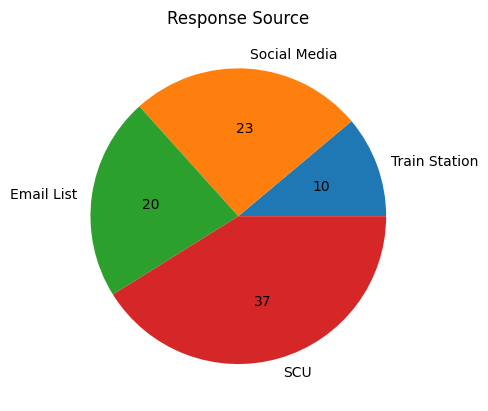

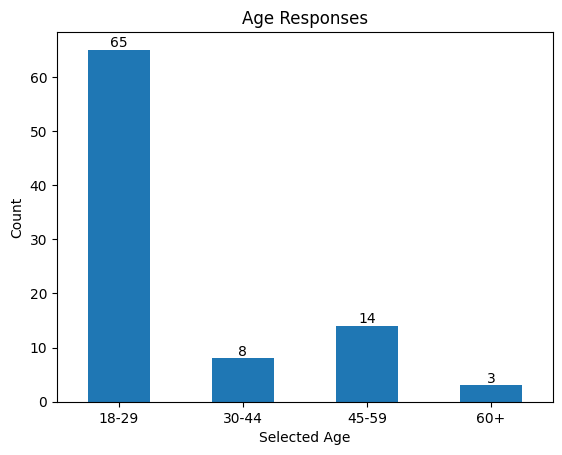

In [95]:
# Basic Data Stats
def print_data_stats(data):
    # print("Data stats:")
    # print(f"- Total Responses: {len(data)}")

    train_station = data[
        (data["StartDate"]
        < pd.Timestamp(year=2024, month=4, day=5)) & (data["DistributionChannel"] == "qr")
    ]
    # print(f"- Responses from Train Station: {len(train_station)}")

    social_media = data[
        (data["StartDate"] < pd.Timestamp(year=2024, month=4, day=5))
        & (data["DistributionChannel"] == "anonymous")
    ]
    # print(f"- Responses from Social Media: {len(social_media)}")

    email_list = data[
        (data["StartDate"] > pd.Timestamp(year=2024, month=4, day=5))
        & (data["DistributionChannel"] == "anonymous")
    ]
    # print(f"- Responses from Email List: {len(email_list)}")

    scu = data[
        (data["StartDate"] > pd.Timestamp(year=2024, month=4, day=5))
        & (data["DistributionChannel"] == "qr")
    ]
    # print(f"- Responses from SCU: {len(scu)}")
    
    # Graph responses
    bar_graph_handle = plt.pie([
        len(train_station),
        len(social_media),
        len(email_list),
        len(scu),
    ], labels = [
        "Train Station",
        "Social Media",
        "Email List",
        "SCU",
    ], autopct=lambda x: f"{np.round(x/100.*len(data), 0):.0f}")
    # plt.bar_label(bar_graph_handle)
    # plt.xticks(rotation=0, ha='center')
    plt.title("Response Source")
    # plt.ylabel("Count")
    plt.show()
    
    # Graph ages
    bar_graph_ax = raw_data["Q28"].value_counts(sort=False).plot(kind='bar')
    plt.bar_label(bar_graph_ax.containers[0])
    plt.xticks(rotation=0, ha='center')
    plt.title("Age Responses")
    plt.ylabel("Count")
    plt.xlabel("Selected Age")
    plt.show()
    

# print_data_stats(data)

In [ ]:
# Map
def map_locations(data):
    home = data[["Q5_1_x", "Q5_1_y"]]
    work = data[["Q6_1_x", "Q6_1_y"]]

    home_np = home.to_numpy()
    work_np = work.to_numpy()
    commute_distances_km = np.linalg.norm(home_np - work_np, axis=1) * KM_PER_PX

    data["commute_distances_km"] = commute_distances_km

    map = image.imread(IMAGE_PATH)

    plt.imshow(map)
    plt.scatter(home["Q5_1_x"], home["Q5_1_y"], c="red", label="Home", alpha=0.5, s=10)
    plt.scatter(work["Q6_1_x"], work["Q6_1_y"], c="blue", label="Work", alpha=0.5, s=10)
    # legend off to the side
    plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.9))
    
    locations = list(data["Q5"].dropna())
    # some location boundries overlap
    location_precedence = ["New Taipei", "Keelung"]
    # split up list
    locations = [location.split(",") for location in locations]
    specific_location = []
    # get the specific, actual location they clicked
    for location in locations:
        for precedence in location_precedence:
            if precedence in location:
                specific_location.append(precedence)
                break
        else: # no break
            specific_location.append(location[0])
    loc_counter = Counter(specific_location)
    label = "Home:\n" + "\n".join(f"{place:>10}: {number:>2}" for place, number in loc_counter.most_common())
    print("Home location, count")
    for place, number in loc_counter.most_common():
        print(f"{place}, {number}")
    
    plt.text(465,120,label, verticalalignment='top', fontname="Fira Code", bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    locations = list(data["Q6"].dropna())
    # some location boundries overlap
    location_precedence = ["New Taipei", "Keelung"]
    # split up list
    locations = [location.split(",") for location in locations]
    specific_location = []
    # get the specific, actual location they clicked
    for location in locations:
        for precedence in location_precedence:
            if precedence in location:
                specific_location.append(precedence)
                break
        else: # no break
            specific_location.append(location[0])
    loc_counter = Counter(specific_location)
    label = "Work:\n" + "\n".join(f"{place:>10}: {number:>2}" for place, number in loc_counter.most_common())
    print()
    print("Work location, count")
    for place, number in loc_counter.most_common():
        print(f"{place}, {number}")
    
    plt.text(695,120,label, verticalalignment='top', fontname="Fira Code", bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # disable axis
    plt.axis("off")
    plt.show()
    
# map_locations(data)

In [ ]:
# Finding correlations in the data

def correlation_to_str(x: float):
    # https://sphweb.bumc.bu.edu/otlt/MPH-Modules/PH717-QuantCore/PH717-Module9-Correlation-Regression/PH717-Module9-Correlation-Regression4.html
    if x == -1:
        return "perfect negative correlation"
    if -1 < x <= -0.8:
        return "very strong negative correlation"
    if -0.8 < x <= -0.6:
        return "strong negative correlation"
    if -0.6 < x <= -0.4:
        return "moderate negative correlation"
    if -0.4 < x <= -0.2:
        return "weak negative correlation"
    if -0.2 < x <= 0.2:
        return "no correlation"
    if 0.2 < x <= 0.4:
        return "weak positive correlation"
    if 0.4 < x <= 0.6:
        return "moderate positive correlation"
    if 0.6 < x <= 0.8:
        return "strong positive correlation"
    if 0.8 < x < 1:
        return "very strong positive correlation"
    if x == 1:
        return "perfect positive correlation"
    raise Exception("Invalid correlation coefficent: " + x)
    
    

def print_correlations(data):
    print("Data correlations:")
    data_pairs = itertools.combinations(data[NUMERIC_QUESTIONS + MULTIPLE_CHOICE_QUESTIONS], 2)

    # checks to see if whole column is the same value
    def is_constant(s):
        a = s.to_numpy()  # s.values (pandas<0.24)
        return (a[0] == a).all()


    for l, r in data_pairs:
        # ignore correlations between multiple choice questions,
        # these are better shown in a correlation matrix
        if l in MULTIPLE_CHOICE_QUESTIONS and r in MULTIPLE_CHOICE_QUESTIONS:
            continue
        
        cols = data[[l, r]].dropna(axis=0, how='any')

        # continue on constant columns
        if is_constant(cols[l]) or is_constant(cols[r]):
            continue

        stats = scipy.stats.pearsonr(cols[l], cols[r])
        # ensure a significant p value and atleast a weak correlation
        if stats.pvalue < 0.05 and stats.pvalue != 0 and stats.statistic > 0.2:
            print(
                f'- "{QUESTION_LOOKUP_TABLE[l]}" has a {correlation_to_str(stats.statistic)} with "{QUESTION_LOOKUP_TABLE[r]}":',
                end="",
            )
            print(f"  correlation={stats.statistic:.3f}, p={stats.pvalue:.4f}", end="")
            print(f"  N={len(cols)}")
            
print_correlations(data)

Data correlations:
- "How often do you use public transportation?" has a weak positive correlation with "How much has 5G affected your quality of life?":  correlation=0.246, p=0.0387  N=71
- "How often do you use public transportation?" has a weak positive correlation with "How familiar are you with AI technology?":  correlation=0.252, p=0.0171  N=89
- "How often do you use public transportation?" has a weak positive correlation with "Initial concerns - Reliability":  correlation=0.263, p=0.0124  N=90
- "How familiar are you with 5G technology?" has a moderate positive correlation with "How familiar are you with AI technology?":  correlation=0.464, p=0.0000  N=89
- "How familiar are you with 5G technology?" has a weak positive correlation with "Select your age range.":  correlation=0.233, p=0.0269  N=90
- "How much has 5G affected your quality of life?" has a weak positive correlation with "How familiar are you with AI technology?":  correlation=0.320, p=0.0069  N=70
- "How much has 5G

In [ ]:
def graph_concerns(data):
    Q21 = data[[f"Q21-{i}" for i in range(len(CONCERNS))][:-1]]
    Q21 = Q21.corr().to_numpy()

    # Q21[np.triu_indices(Q21.shape[0])] = np.nan

    label = "Key:\n" +"\n".join([f"{i}. {concern}" for i, concern in enumerate(CONCERNS)][:-1])

    plt.matshow(Q21)
    plt.colorbar(label="Correlation")
    plt.title("Concerns Correlation")
    plt.text(-0.5,8,label, fontname="Fira Code",bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    # Show text on matrix
    for (y, x), value in np.ndenumerate(Q21):
        # skip un-interesting values
        if abs(value) < 0.2 or value == 1:
            continue
        plt.text(x, y, f"{value:.2f}", va="center", ha="center")
    plt.show()

    # POSITIVE_CONNECTION_THRESHOLD = 0.3
    # connections = (
    #     np.logical_or(Q21 > POSITIVE_CONNECTION_THRESHOLD, np.eye(Q21.shape[0]))
    # ).nonzero()
    # connections = np.transpose(connections)
    # plot_instance = netgraph.Graph(connections)
    # plt.show()
    
    counts = [sum(data[f"Q21-{i}"]) for i in range(len(CONCERNS))]
    sorted = list(zip(CONCERNS, counts))
    sorted.sort(key=lambda i: i[1], reverse=True)
    # print("Concerns:")
    # for concern, count in sorted:
    #     print(f"- {concern} {count:.0f}")
    bar_graph_handle = plt.bar(*list(zip(*sorted)))
    plt.bar_label(bar_graph_handle)
    plt.xticks(rotation=35, ha='right')
    plt.title("Concern Responses")
    plt.ylabel("Count")
    plt.show()

# graph_concerns(data)

In [ ]:
def preference_changes(data: pd.DataFrame):
    initial_pref_idx = "Q18"
    final_pref_idx = "Q25"
    data_copy = data.copy()
    # Identify the rows where Q23 is "No"
    no_indices = data_copy["Q23"] == "No"

    # set values for Q25 where Q23 is "No"
    data_copy.loc[no_indices, final_pref_idx] = data_copy.loc[no_indices, initial_pref_idx]
    
    # get list of changes
    change_idx = data_copy[initial_pref_idx] != data_copy[final_pref_idx]
    changes = (data_copy[[initial_pref_idx, final_pref_idx]])[change_idx]
    # shift numbers to be all positive so they can be used as matrix indices
    changes = changes.map(lambda x: x + 1).astype(int)
    change_matrix = np.zeros((3,3))
    for index, row in changes.iterrows():
        change_matrix[row.iloc[0], row.iloc[1]] += 1
        
    fig, ax = plt.subplots()
    img = ax.matshow(change_matrix)
    fig.colorbar(img, label="Count", ticks=np.arange(np.min(change_matrix), np.max(change_matrix) + 1))
    plt.title("How people changed their mind:\nWould you prefer this over the current system?")
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_ticks([0, 1, 2])
    ax.yaxis.set_ticks([0, 1, 2])
    ax.set_xticklabels(["No", "Maybe", "Yes"])
    ax.set_yticklabels(["No", "Maybe", "Yes"])
    plt.ylabel("Initial Choice", fontweight='bold')
    plt.xlabel("Final Choice", fontweight='bold')
    # draw in cell numbers
    for (y, x), value in np.ndenumerate(change_matrix):
        plt.text(x, y, f"{value:.0f}", va="center", ha="center")
    plt.show()
        
# preference_changes(data)

In [ ]:
def concerns_changes(data: pd.DataFrame):
    initial_concerns_idx = "Q21"
    final_concerns_idx = "Q27"
    data_copy = data.copy()
    # Identify the rows where Q23 is "No"
    no_change_indices = (data_copy["Q23"] == "No").to_numpy()
    
    initial = data[[f"{initial_concerns_idx}-{i}" for i in range(len(CONCERNS)-1)]].astype(int).to_numpy()
    final = data[[f"{final_concerns_idx}-{i}" for i in range(len(CONCERNS)-1)]].astype(int).to_numpy()
    # where they didn't change answers, make final match initial
    # just a quirk of how the data has been processed
    final[no_change_indices] = initial[no_change_indices]
    change_mask = final != initial
    change_indices = np.transpose(change_mask.nonzero())
    
    # col 0 is selected
    # col 1 is de-selected
    # rows correspond to the values of CONCERNS
    change_matrix = np.zeros((len(CONCERNS)-1,2))
    for change_index in change_indices:
        initial_selection = initial[change_index[0], change_index[1]]
        change_matrix[change_index[1], initial_selection] += 1

    fig, ax = plt.subplots()
    img = ax.matshow(change_matrix)
    fig.colorbar(img, label="Count", ticks=np.arange(np.min(change_matrix), np.max(change_matrix) + 1))
    plt.title("How people changed their mind:\nCheck all concerns that you might have with a system like this.")
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_ticks([0, 1])
    ax.yaxis.set_ticks(list(range(len(CONCERNS)-1)))
    ax.set_xticklabels(["Selected", "De-Selected"])
    ax.set_yticklabels(CONCERNS[:-1])
    plt.ylabel("Initial Choice", fontweight='bold')
    plt.xlabel("Final Choice", fontweight='bold')
    # plt.yticks(rotation=35, ha='right')
    plt.xticks(rotation=35, ha='right')
    # draw in cell numbers
    for (y, x), value in np.ndenumerate(change_matrix):
        plt.text(x, y, f"{value:.0f}", va="center", ha="center")
    plt.show()
    
        
# concerns_changes(data)

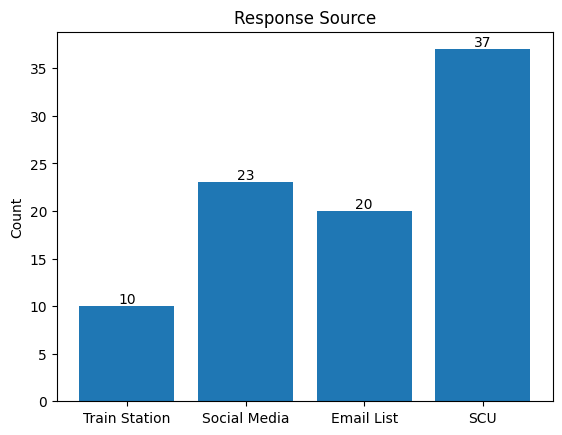

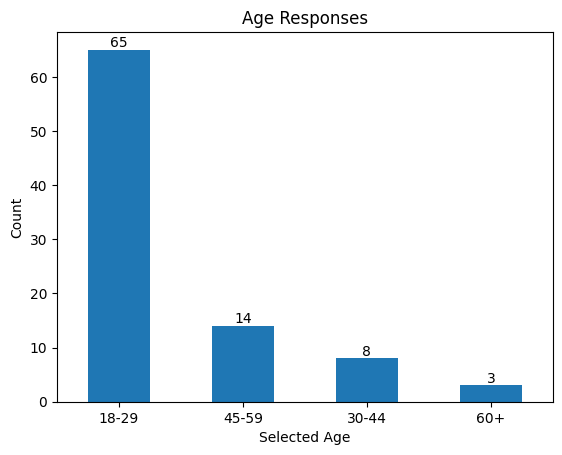





Data map:
Home location, count
New Taipei, 21
Taipei, 19
Taoyuan, 12
Hsinchu, 7
Taichung, 6
Tainan, 3
Other, 3
Keelung, 3
Changhua, 3
Pingtung, 2
Kaohsiung, 1
Miaoli, 1
Nantou, 1
Chiayi, 1
Yilan, 1

Work location, count
Taipei, 36
New Taipei, 22
Taoyuan, 11
Hsinchu, 6
Tainan, 3
Other, 3
Taichung, 1
Nantou, 1


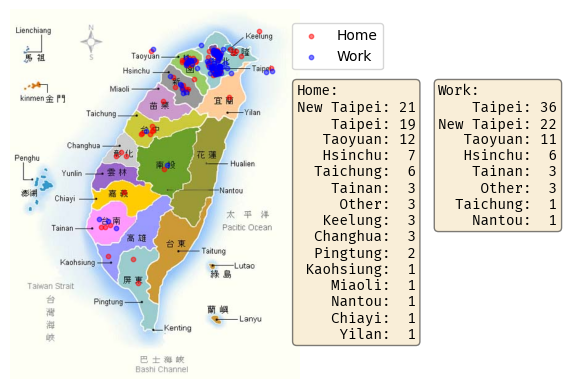





Data correlations:
- "How often do you use public transportation?" strongly correlates with "How much has 5G affected your quality of life?":  correlation=0.246, p=0.0387  N=71
- "How often do you use public transportation?" strongly correlates with "How familiar are you with AI technology?":  correlation=0.252, p=0.0171  N=89
- "How often do you use public transportation?" strongly correlates with "Initial concerns - Reliability":  correlation=0.263, p=0.0124  N=90
- "How familiar are you with 5G technology?" strongly correlates with "How familiar are you with AI technology?":  correlation=0.464, p=0.0000  N=89
- "How familiar are you with 5G technology?" strongly correlates with "Select your age range.":  correlation=0.233, p=0.0269  N=90
- "How much has 5G affected your quality of life?" strongly correlates with "How familiar are you with AI technology?":  correlation=0.320, p=0.0069  N=70
- "How much has 5G affected your quality of life?" strongly correlates with "Initial conce

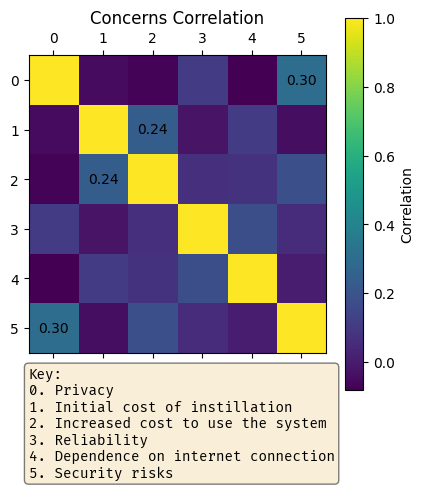

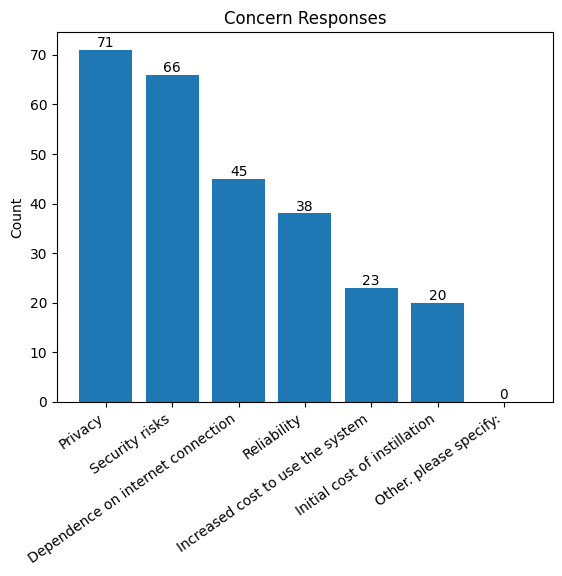

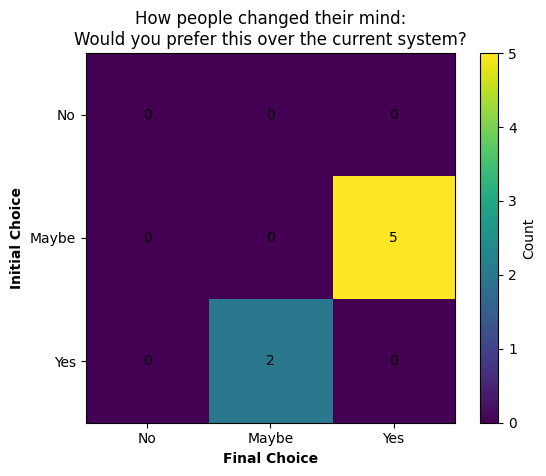

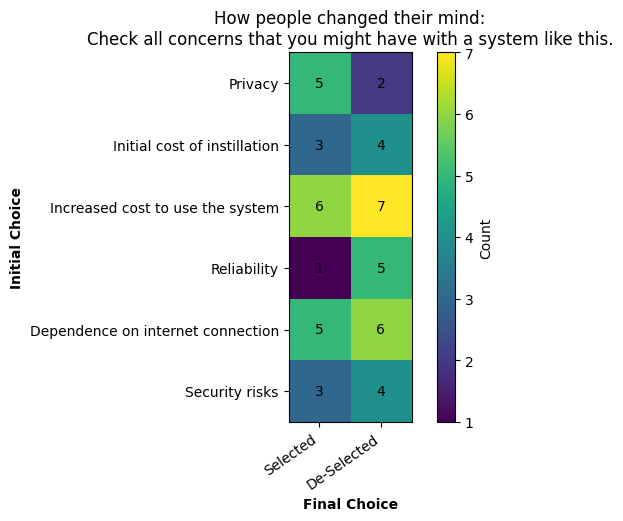

In [ ]:

def full_analysis(data):
    print_data_stats(data)

    print("\n"*3)
    print("Data map:")
    map_locations(data)

    print("\n"*3)
    print_correlations(data)

    print("\n"*3)
    print("Concerns graph:")
    graph_concerns(data)
    
    preference_changes(data)
    concerns_changes(data)

full_analysis(data)
# map_locations(data)